Mounted at /content/drive
Epoch 1 | Train Loss: 1.3549
Val Accuracy: 0.5199
Epoch 2 | Train Loss: 1.1671
Val Accuracy: 0.5790
Epoch 3 | Train Loss: 1.0411
Val Accuracy: 0.5828
Epoch 4 | Train Loss: 0.8845
Val Accuracy: 0.5670
Epoch 5 | Train Loss: 0.7360
Val Accuracy: 0.5566
Epoch 6 | Train Loss: 0.5865
Val Accuracy: 0.5603
Epoch 7 | Train Loss: 0.4606
Val Accuracy: 0.5820

🎯 Test Accuracy: 0.5696


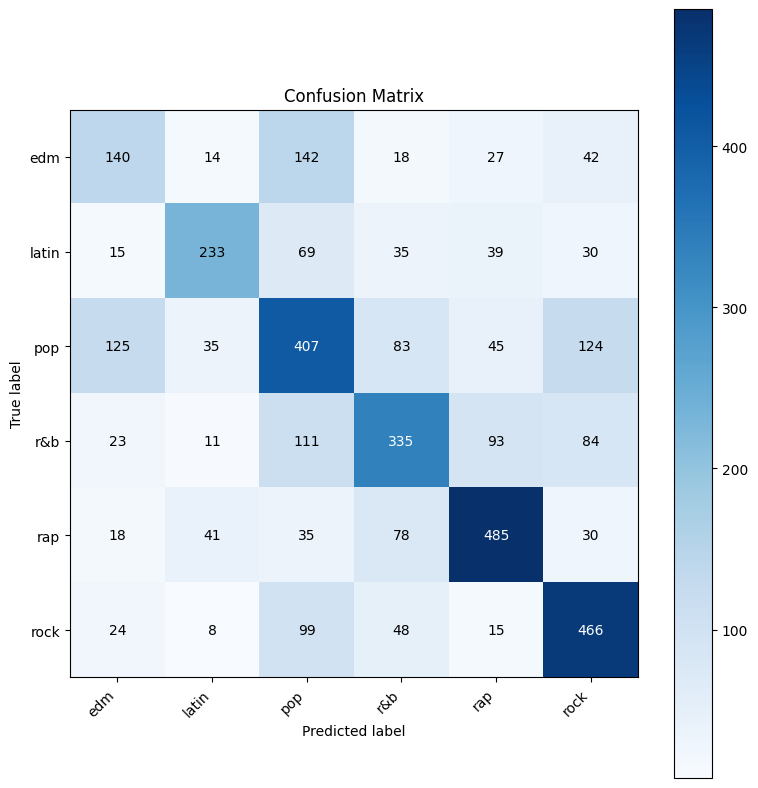


📋 Classification Report:
              precision    recall  f1-score   support

         edm     0.4058    0.3655    0.3846       383
       latin     0.6813    0.5534    0.6107       421
         pop     0.4716    0.4969    0.4839       819
         r&b     0.5611    0.5099    0.5343       657
         rap     0.6889    0.7060    0.6973       687
        rock     0.6005    0.7061    0.6490       660

    accuracy                         0.5696      3627
   macro avg     0.5682    0.5563    0.5600      3627
weighted avg     0.5698    0.5696    0.5678      3627



In [1]:
# --- 0. Setup ---
!pip install torchinfo

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
from torchinfo import summary

# --- 1. Data Preparation ---

# Mount drive if needed
from google.colab import drive
drive.mount('/content/drive')

# Load cleaned data
file_path = '/content/drive/My Drive/CS5242 Assignment'
df_all = pd.read_csv(file_path+'/spotify_songs.csv')
train_df = pd.read_csv(file_path+'/train_df_with_artist.csv')
test_df = pd.read_csv(file_path+'/test_df_with_artist.csv')

# Audio features columns
audio_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'duration_ms']

# Tokenization utilities
def simple_tokenizer(text):
    import re
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    return tokens

def build_vocab(texts, vocab_size=10000):
    tokenized = [simple_tokenizer(t) for t in texts]
    from collections import Counter
    counter = Counter(tok for tokens in tokenized for tok in tokens)
    special_tokens = ['<PAD>', '<UNK>']
    most_common = counter.most_common(vocab_size - len(special_tokens))
    vocab = special_tokens + [w for w, _ in most_common]
    word2idx = {w: i for i, w in enumerate(vocab)}
    return word2idx, vocab

def encode_text(text, word2idx, max_len=256):
    tokens = simple_tokenizer(text)
    ids = [word2idx.get(t, word2idx['<UNK>']) for t in tokens]
    ids = ids[:max_len] + [word2idx['<PAD>']] * max(0, max_len - len(ids))
    mask = [1 if i != word2idx['<PAD>'] else 0 for i in ids]
    return ids, mask

# Build vocab
all_lyrics = pd.concat([train_df['lyrics'], test_df['lyrics']])
word2idx, vocab = build_vocab(all_lyrics.tolist())

# Add tokenized columns
def add_tokenized_columns(df, word2idx, max_len=256):
    result = [encode_text(text, word2idx, max_len) for text in df['lyrics']]
    df['lyrics_input_ids'] = [r[0] for r in result]
    df['lyrics_attention_mask'] = [r[1] for r in result]
    return df

train_df = add_tokenized_columns(train_df, word2idx)
test_df = add_tokenized_columns(test_df, word2idx)

# Encode genre
all_genres = pd.concat([train_df['playlist_genre'], test_df['playlist_genre']])
genre2idx = {genre: idx for idx, genre in enumerate(all_genres.astype('category').cat.categories)}
train_df['genre_idx'] = train_df['playlist_genre'].map(genre2idx)
test_df['genre_idx'] = test_df['playlist_genre'].map(genre2idx)

# Split val set
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['genre_idx'], random_state=42)

# --- 2. Dataset ---

class SongsDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_vals = row[audio_cols].to_numpy(dtype=np.float32)
        audio = torch.from_numpy(audio_vals)
        missing_flag = torch.tensor([float(False)], dtype=torch.float)
        audio_feat = torch.cat((audio, missing_flag), dim=0)
        input_ids = torch.tensor(row['lyrics_input_ids'], dtype=torch.long)
        attention_mask = (input_ids != word2idx['<PAD>']).long()
        label = torch.tensor(row['genre_idx'], dtype=torch.long)
        return audio_feat, input_ids, attention_mask, label

train_ds = SongsDataset(train_df)
val_ds = SongsDataset(val_df)
test_ds = SongsDataset(test_df)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# --- 3. Model ---

class MultiModalNet(nn.Module):
    def __init__(self, num_genres, audio_dim, vocab_size, hidden_dim=128):
        super().__init__()
        self.text_emb = nn.Embedding(vocab_size, hidden_dim)
        self.lyrics_gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_genres)
        )

    def forward(self, audio_feat, input_ids, attention_mask):
        t = self.text_emb(input_ids)
        t, _ = self.lyrics_gru(t)
        q = self.audio_proj(audio_feat).unsqueeze(1)
        attn_out, _ = self.cross_attn(q, t, t, key_padding_mask=(1 - attention_mask).bool())
        fused = attn_out.squeeze(1)
        return self.classifier(fused)

# --- 4. Training ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_genres = len(genre2idx)
audio_dim = len(audio_cols) + 1

model = MultiModalNet(num_genres, audio_dim, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(7):
    model.train()
    total_loss = 0
    for audio_feat, input_ids, attention_mask, labels in train_loader:
        audio_feat, input_ids, attention_mask, labels = [x.to(device) for x in (audio_feat, input_ids, attention_mask, labels)]
        optimizer.zero_grad()
        logits = model(audio_feat, input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for audio_feat, input_ids, attention_mask, labels in val_loader:
            audio_feat, input_ids, attention_mask, labels = [x.to(device) for x in (audio_feat, input_ids, attention_mask, labels)]
            preds = model(audio_feat, input_ids, attention_mask).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Val Accuracy: {correct/total:.4f}")

# --- 5. Evaluation ---

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for audio_feat, input_ids, attention_mask, labels in test_loader:
        audio_feat, input_ids, attention_mask, labels = [x.to(device) for x in (audio_feat, input_ids, attention_mask, labels)]
        logits = model(audio_feat, input_ids, attention_mask)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
classes = list(genre2idx.keys())

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j] > thresh else 'black')
plt.tight_layout()
plt.show()

# Classification Report
idx2genre = [genre for genre, idx in sorted(genre2idx.items(), key=lambda x: x[1])]
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=idx2genre, digits=4))
